# Task 3: Approximating nonlinear vector fields

In [1]:
from helpers.data import load_dataset
from helpers.models import RBFRegression, get_best_model
import helpers.vectorfields as vf
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
import pandas as pd
import numpy as np

In [2]:
#load data
x_0 = load_dataset("data/nonlinear_vectorfield_data_x0.txt")
x_1 = load_dataset("data/nonlinear_vectorfield_data_x1.txt")

In [3]:
print(x_0.shape)
print(x_1.shape)

(2000, 2)
(2000, 2)


In [4]:
print(x_0)
print(x_1)

             x         y
0    -0.746802  1.982920
1    -4.498971 -1.779007
2    -3.179197 -3.668953
3    -2.823658 -1.389953
4    -0.929093  0.349351
...        ...       ...
1995 -3.650647  3.594317
1996 -3.890063  1.626321
1997  4.247983  1.884364
1998 -1.566822 -3.839039
1999  0.717633  2.101653

[2000 rows x 2 columns]
             x         y
0    -0.793170  2.098244
1    -4.200666 -1.955218
2    -3.323446 -3.549717
3    -2.905656 -1.480816
4    -0.982742  0.428147
...        ...       ...
1995 -3.475128  3.497376
1996 -3.664949  1.735261
1997  3.937381  1.836732
1998 -1.791530 -3.591236
1999  0.788361  2.178699

[2000 rows x 2 columns]


<AxesSubplot:xlabel='x', ylabel='y'>

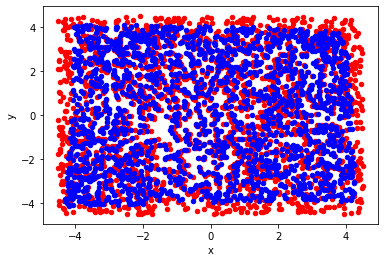

In [5]:
# visualize input data
ax = x_0.plot(kind = 'scatter', x = 'x', y = 'y', color='r')

x_1.plot(kind = 'scatter', x = 'x', y = 'y', color='b', ax=ax)

### Part 1: Estimate the vector field with a linear operator

In [6]:
delta_t = 0.1 # delta_t is unknown at this point so just set it to 0.1
v_k = vf.compute_finite_difference(x_0, x_1, delta_t)
A_T = vf.compute_closed_form_linear(x_0, v_k)


In [7]:
print(A_T.T)

          x         y
x -0.100160 -0.002535
y  0.008673 -0.432671


In [8]:
max_t = 1
num_t = 100
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_linear(time, A_T.to_numpy(), x_0)

In [9]:
# find best approximation, error and delta_t
best_error = np.inf
best_x_i = X_i_head[0].reshape(x_0.shape[0], x_0.shape[1])
best_t = 0

for i, x_i in enumerate(X_i_head):
    x_i = x_i.reshape(x_0.shape[0], x_0.shape[1])
    mse = vf.mean_squared_error(x_i, x_1.to_numpy())
    if mse < best_error:
        best_t = i / num_t * max_t
        best_x_i = x_i
        best_error = mse

print("Mean Squared Error is: " + str(best_error))
print("Best delta_t is: " + str(best_t))

Mean Squared Error is: 0.018635903091531413
Best delta_t is: 0.1


In [10]:
print(v_k.x)

0      -0.463684
1       2.983042
2      -1.442493
3      -0.819981
4      -0.536490
          ...   
1995    1.755187
1996    2.251134
1997   -3.106025
1998   -2.247089
1999    0.707280
Name: x, Length: 2000, dtype: float64


### Part 2: Estimate the vector field with radial basis functions

In [11]:
param_grid_rbf_regression = {
    "lamb": loguniform(1e-6, 1e-4),
    "eps": loguniform(1e-2, 1e2),
    "L": randint(900, 1000),
}
rbf_x = RBFRegression()
best_model_x = get_best_model(param_grid_rbf_regression, rbf_x, x_0.x.to_numpy(), v_k.x.to_numpy(), n_iter=50)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best R2 score:
0.7942059678445912
Best params:
{'L': 980, 'eps': 6.260038856370348, 'lamb': 4.194455755871931e-06}


In [12]:
rbf_y = RBFRegression()
best_model_y = get_best_model(param_grid_rbf_regression, rbf_y, x_0.y.to_numpy(), v_k.y.to_numpy(), n_iter=50)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best R2 score:
0.8599768215053242
Best params:
{'L': 939, 'eps': 5.435720553612618, 'lamb': 4.20371602782345e-06}


In [13]:
max_t = 1
num_t = 100
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_nonlinear(time, best_model_x, x_0.x)
Y_i_head = vf.solve_ode_nonlinear(time, best_model_y, x_0.y)

In [14]:
def concatenate_dimensions(X_i: np.ndarray, Y_i: np.ndarray) -> np.ndarray:
    """
    concatenates X_i and Y_i to one array
    Args:
        X_i (np.ndarray): array of shape (T, N) with values for different points in time
        Y_i (np.ndarray): array of shape (T, N) with values for different points in time

    Returns: array of shape (T, N, 2)

    """
    X_modified = np.expand_dims(X_i, axis=-1)
    Y_modified = np.expand_dims(Y_i, axis=-1)
    return np.concatenate((X_modified, Y_modified), axis=-1)

In [15]:
result = concatenate_dimensions(X_i_head, Y_i_head)
print(result.shape)

(100, 2000, 2)


In [16]:
# find best approximation, error and delta_t
best_error = np.inf
best_x_i = result[0]
best_t = 0

for i, x_i in enumerate(result):
    mse = vf.mean_squared_error(x_i, x_1.to_numpy())
    if mse < best_error:
        best_t = i / num_t * max_t
        best_x_i = x_i
        best_error = mse

print("Mean Squared Error is: " + str(best_error))
print("Best delta_t is: " + str(best_t))

Mean Squared Error is: 0.004262825351275235
Best delta_t is: 0.11


### Part 3: Analysis of the dynamical system

solve the system for a longer period of time with all initial points x.

In [17]:
max_t = 100
num_t = 100
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_nonlinear(time, best_model_x, x_0.x)

In [18]:
Y_i_head = vf.solve_ode_nonlinear(time, best_model_y, x_0.y)

In [19]:
result = concatenate_dimensions(X_i_head, Y_i_head)
print(result.shape)

(100, 2000, 2)


Find the steady states by visualizing the final points of t_end.

(2000, 2)
             x         y
0    -3.251222  2.729410
1    -3.251222 -2.427044
2    -3.251222 -2.427044
3    -3.251222 -2.427044
4    -3.251222  2.729410
...        ...       ...
1995 -3.251222  2.729410
1996 -3.251222  2.729410
1997  3.232514  2.729410
1998 -3.251222 -2.427044
1999  3.232514  2.729410

[2000 rows x 2 columns]


<AxesSubplot:xlabel='x', ylabel='y'>

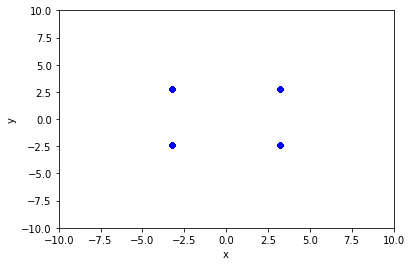

In [20]:
x_i_final = result[-1]
print(x_i_final.shape)
df = pd.DataFrame(data=x_i_final, columns=x_1.columns)
print(df)

df.plot(kind = 'scatter', x = 'x', y = 'y', color='b', xlim=(-10, 10), ylim=(-10, 10))


One is able to identify 4 steady states at (-3.2, -2.4), (-3.2, 2.7), (3.2, -2.4) and (3.2, 2.7)

Visualize the trajectory of some initial points. One is able to assume there is at least an additional repulsive steady state in the area between the points (-0.1, 0.1), (-0.1,-0.5), (0.1,-0.5) and (0,0)

<AxesSubplot:xlabel='x'>

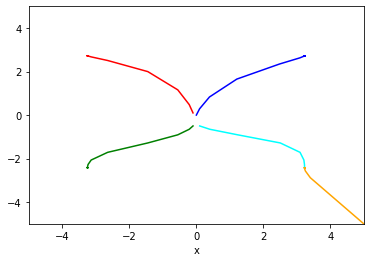

In [21]:
# visualize trajectories of some initial points
def get_trajectory(initial: pd.DataFrame) -> pd.DataFrame:
    """
    computes trajectory of initial point
    Args:
        initial (pd.DataFrame): starting point

    Returns: pd.DataFrame of shape (T, D) that represents trajectory

    """
    x_1_head_x = vf.solve_ode_nonlinear(time, best_model_x, initial.x)
    x_1_head_y = vf.solve_ode_nonlinear(time, best_model_y, initial.y)
    x_1_head = concatenate_dimensions(x_1_head_x, x_1_head_y)
    return pd.DataFrame(data=np.squeeze(x_1_head, axis=1), columns=x_1.columns)

initial_0 = pd.DataFrame(data=[(0,0)], columns=x_0.columns)
initial_1 = pd.DataFrame(data=[(-0.1,0.1)], columns=x_0.columns)
initial_2 = pd.DataFrame(data=[(-0.1,-0.5)], columns=x_0.columns)
initial_3 = pd.DataFrame(data=[(0.1,-0.5)], columns=x_0.columns)
initial_4 = pd.DataFrame(data=[(5,-5)], columns=x_0.columns)

df_0 = get_trajectory(initial_0)
df_1 = get_trajectory(initial_1)
df_2 = get_trajectory(initial_2)
df_3 = get_trajectory(initial_3)
df_4 = get_trajectory(initial_4)

ax = df_0.plot(kind = 'line', x = 'x', y = 'y', color='blue', xlim=(-5,5), ylim=(-5,5), legend=False)
df_1.plot(kind = 'line', x = 'x', y = 'y', color='red', xlim=(-5,5), ylim=(-5,5), legend=False, ax=ax)
df_2.plot(kind = 'line', x = 'x', y = 'y', color='green', xlim=(-5,5), ylim=(-5,5), legend=False, ax=ax)
df_3.plot(kind = 'line', x = 'x', y = 'y', color='cyan', xlim=(-5,5), ylim=(-5,5), legend=False, ax=ax)
df_4.plot(kind = 'line', x = 'x', y = 'y', color='orange', xlim=(-5,5), ylim=(-5,5), legend=False, ax=ax)